In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
from collections import namedtuple, deque, OrderedDict
import pandas as pd

In [2]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [3]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
state_size = len(env_info.vector_observations[0])
action_size = brain.vector_action_space_size

print(brain_name)

BananaBrain


In [6]:
def QNet(state_size=state_size, action_size=action_size, seed=10, fc1=256, fc2=512):
    torch.manual_seed(seed)
    return nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(state_size, fc1)),
        ('relu1', nn.ReLU()),
        ('dropout1', nn.Dropout(p=0.25)),
        ('fc2', nn.Linear(fc1, fc2)),
        ('relu2', nn.ReLU()),
        ('dropout2', nn.Dropout(p=0.25)),
        
        ('output', nn.Linear(fc2, action_size))
    ]))

In [7]:
BUFFER_SIZE = 100000
BATCH_SIZE = 64
GAMMA = 0.995
TAU = 1e-3 
LR = 0.001
UPDATE_EVERY = 4 # how often to update the network

In [8]:
episodes = 1000
horizon_t = 1000

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
class ReplayBuffer():
    """Create the replay buffer to store the experience from the env as (s,a,r,s',done)"""
    
    def __init__(self, buffer_size, batch_size, seed=231):
        """Initialize ReplayBuffer.
        
        Params
        ======
            buffer_size (int): (maximal) capacity of the buffer and size of sampled experiences
            batch_size (int): size of the random samples
            seed (int): randomize
        """
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add the tuple s,a,r,s',done) in the experience replay buffer
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Sample random experiences with the size of batch_size.
        Returns a tuple (s,a,r,s',dones), each item as a torch vector
        """
        
        samples = random.sample(self.memory, self.batch_size)
        
        #return torch tensors
        states = torch.from_numpy(np.vstack([e.state for e in samples if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in samples if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in samples if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in samples if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in samples if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

In [11]:
class Agent():
   
    def __init__(self, state_size, action_size, seed=231):
        self.state_size = state_size
        self.action_size = action_size
        self.qnet_local = QNet(state_size, action_size).to(device)
        self.qnet_target = QNet(state_size, action_size).to(device)
        self.replay = ReplayBuffer(buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE)
        self.t_steps = 0
        self.optimizer = optim.Adam(params=self.qnet_local.parameters(), lr=LR)
        random.seed(seed)
        
        
    def act(self, state, eps):
        #select the next state based on policy
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnet_local.eval()
        with torch.no_grad():
            action_values = self.qnet_local(state)
        self.qnet_local.train()
        
        if random.random() > eps:
            # go greedy
            #when run in gpu mode, tensor's data cannot be converted to numpy
            return np.argmax(action_values.data.cpu().numpy()) 
        else:
            #random action
            return np.random.choice(np.arange(self.action_size))
        
        
    def step(self, state, action, reward, next_state, done):
        self.replay.add(state, action, reward, next_state, done)
        self.t_steps += 1
        if self.t_steps % UPDATE_EVERY == 0:
            # check if enough samples
            if self.replay.__len__() > BATCH_SIZE:
                subset = self.replay.sample()
                self.learn(subset, GAMMA)
                
            
    def learn(self, experience, gamma):
        state, action, reward, next_state, done = experience
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnet_target(next_state).detach().max(1)[0].unsqueeze(1) #lid
        # Compute Q targets for current states 
        Q_targets = reward + (gamma * Q_targets_next * (1 - done))
        Q_expected = self.qnet_local(state).gather(1, action) #view in details
        
        loss = nn.functional.mse_loss(Q_expected, Q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.qnet_local, self.qnet_target)
        
        
    def soft_update(self, local_model, target_model, tau=TAU):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        

In [12]:
agent = Agent(state_size=state_size, action_size=action_size, seed=10)

In [13]:
def dqn(episodes, horizion_t, eps_start = 0.99, eps_end = 0.01, eps_decay = 0.995):
    scores = []
    scores_win = deque(maxlen=100) #last consecutive episode scores
    eps = eps_start
    for e in range(1, episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(horizion_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_win.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_win)), end=" ")
        if e % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_win)))
        if np.mean(scores_win)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - len(scores_win) + 1,
                                                                                         np.mean(scores_win)))
            torch.save(agent.qnet_local.state_dict(), 'checkpoint_navigation.pth')
            break
    return scores

In [14]:
scores = dqn(episodes=episodes, horizion_t=horizon_t)

Episode 100	Average Score: 0.32 
Episode 200	Average Score: 2.55 
Episode 300	Average Score: 6.44 
Episode 400	Average Score: 10.77 
Episode 500	Average Score: 12.10 
Episode 555	Average Score: 13.09 
Environment solved in 456 episodes!	Average Score: 13.09


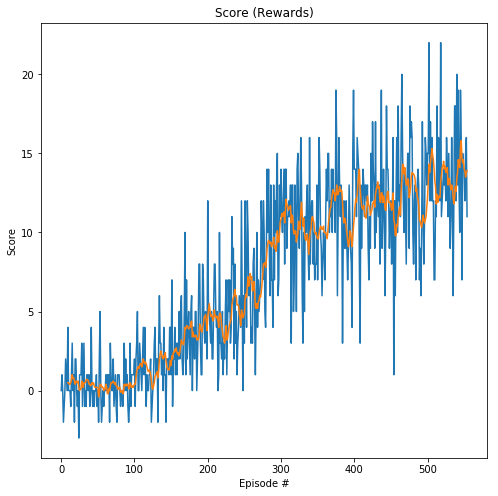

In [15]:
# plot the scores
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(pd.Series(scores).rolling(10).mean())
plt.title('Score (Rewards)')
plt.ylabel('Score')
plt.xlabel('Episode #')   
plt.show()

In [16]:
#when done, close the env
env.close()

In [17]:
##